In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Model selection

In [2]:
raw = pd.read_csv('/kaggle/input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv')
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"n't", ' not', text)
    text = re.sub(r"\W|[\r\n]+", ' ', text) # remove not-words and newlines
    text = re.sub(r"\s{2,}", ' ', text) # remove '.', ',' and doubled whitespaces
    
    tokenized = [word for word in text.split() if word not in stopwords.words('english')] # remove stopwords
    text = ' '.join(tokenized)
    return text

df = raw
df['Review'] = df['Review'].map(preprocess_text)
df['Review_length'] = df['Review'].map(lambda x: len(x.split()))

Let's devide our data set into train and test set with 80:20 ratio and tokenize texts into integers. We will use padding to fix sample size (one review length) to 300 as we previously observed during EDA that 96% of reviews have 300 or less words.

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

MAX_NUM_WORDS = 5000
MAX_VECTOR_LEN = 300

x_train, x_test, y_train, y_test = train_test_split(df['Review'], df['Rating'], test_size=0.20, random_state=42)

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)


x_train = pad_sequences(x_train, padding='post', maxlen=MAX_VECTOR_LEN)
x_test = pad_sequences(x_test, padding='post', maxlen=MAX_VECTOR_LEN)

In [4]:
# exemplary review after transformations
x_train[1][:20]

array([ 325, 2713, 1575,  112, 3082,  928,    1,   64,   30,  224,  435,
        506,  437,   17, 1562,  310, 1390,  887,   52,   28], dtype=int32)

Importing pre-train word vectors created with GloVe algorithm to create embbeding matrix. `glove.6B.300d.txt` contains 400,000 words represented in 300-dimensional vectors. Among 5000 words in our vocabulary, only 71 weren't present in GloVe file. Now our vocabulary is mapped into 300d vector space.

In [5]:
embedding_dict = dict()
with open('/kaggle/input/glove6b/glove.6B.300d.txt', encoding='utf8') as file:
    for line in file:
        splitted_line = line.split()
        word = splitted_line[0]
        vector_vals = np.asarray(splitted_line[1:], dtype='float32')
        embedding_dict[word] = vector_vals

In [6]:
embedding_matrix = np.zeros((MAX_NUM_WORDS, 300))
non_found_counter = 0
for word, index in tokenizer.word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None and index < MAX_NUM_WORDS:
        embedding_matrix[index] = embedding_vector
    if embedding_vector is None and index < MAX_NUM_WORDS:
        non_found_counter += 1

In [7]:
embedding_matrix.shape, non_found_counter

((5000, 300), 71)

## Baseline model
First, let's establish baseline models. These can be median- and mean-based dummy models:

In [8]:
from sklearn.metrics import mean_squared_error
print("Mean-based baseline model for test set:")
print(mean_squared_error(y_test, np.repeat(y_test.mean(), len(y_test)), squared=False))
print("Median-based baseline model for test set:")
print(mean_squared_error(y_test, np.repeat(y_test.median(), len(y_test)), squared=False))

Mean-based baseline model for test set:
1.2272561684403211
Median-based baseline model for test set:
1.2280768400449915


## Simple dense network

First, let's try with the simplest neural network containing embedding layer based on previously created `embedding_matrix`.

In [9]:
from tensorflow import keras
model = keras.Sequential([
    keras.layers.Embedding(MAX_NUM_WORDS, 300, weights=[embedding_matrix],
                          input_length=MAX_VECTOR_LEN, trainable=False),
    keras.layers.Flatten(),
    keras.layers.Dense(1)
])
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0003), loss='mean_squared_error', metrics=['mean_squared_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          1500000   
_________________________________________________________________
flatten (Flatten)            (None, 90000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 90001     
Total params: 1,590,001
Trainable params: 90,001
Non-trainable params: 1,500,000
_________________________________________________________________


In [10]:
history = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_split=0.2)

Epoch 1/20
410/410 [==============================] - 4s 6ms/step - loss: 2.6733 - mean_squared_error: 2.6733 - val_loss: 0.9162 - val_mean_squared_error: 0.9162
Epoch 2/20
410/410 [==============================] - 2s 5ms/step - loss: 0.8922 - mean_squared_error: 0.8922 - val_loss: 0.9945 - val_mean_squared_error: 0.9945
Epoch 3/20
410/410 [==============================] - 2s 5ms/step - loss: 1.1284 - mean_squared_error: 1.1284 - val_loss: 0.9457 - val_mean_squared_error: 0.9457
Epoch 4/20
410/410 [==============================] - 2s 5ms/step - loss: 1.0377 - mean_squared_error: 1.0377 - val_loss: 1.0231 - val_mean_squared_error: 1.0231
Epoch 5/20
410/410 [==============================] - 2s 5ms/step - loss: 0.8117 - mean_squared_error: 0.8117 - val_loss: 0.9952 - val_mean_squared_error: 0.9952
Epoch 6/20
410/410 [==============================] - 2s 5ms/step - loss: 0.5910 - mean_squared_error: 0.5910 - val_loss: 1.1042 - val_mean_squared_error: 1.1042
Epoch 7/20
410/410 [========

Oscillating loss of train dataset may indicate too high learning rate. Let's try again with the lower one.

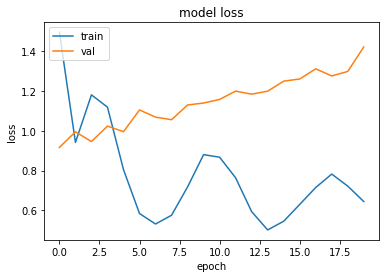

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [12]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.00003), loss='mean_squared_error', metrics=['mean_squared_error'])

In [13]:
history = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_split=0.2)

Epoch 1/20
410/410 [==============================] - 3s 6ms/step - loss: 0.5858 - mean_squared_error: 0.5858 - val_loss: 1.2796 - val_mean_squared_error: 1.2796
Epoch 2/20
410/410 [==============================] - 2s 5ms/step - loss: 0.3764 - mean_squared_error: 0.3764 - val_loss: 1.2599 - val_mean_squared_error: 1.2599
Epoch 3/20
410/410 [==============================] - 2s 5ms/step - loss: 0.2201 - mean_squared_error: 0.2201 - val_loss: 1.2473 - val_mean_squared_error: 1.2473
Epoch 4/20
410/410 [==============================] - 2s 5ms/step - loss: 0.1541 - mean_squared_error: 0.1541 - val_loss: 1.2462 - val_mean_squared_error: 1.2462
Epoch 5/20
410/410 [==============================] - 2s 5ms/step - loss: 0.1085 - mean_squared_error: 0.1085 - val_loss: 1.2429 - val_mean_squared_error: 1.2429
Epoch 6/20
410/410 [==============================] - 2s 5ms/step - loss: 0.0908 - mean_squared_error: 0.0908 - val_loss: 1.2431 - val_mean_squared_error: 1.2431
Epoch 7/20
410/410 [========

In this case model quickly converges, unfortunetly with poor performence for validation dataset and huge overfitting.

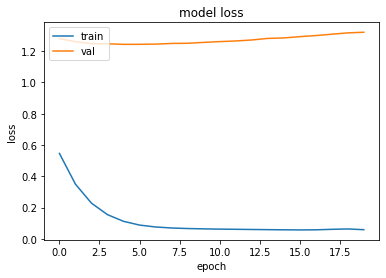

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

## CNN
Now, let's try CNN. Convolutional layers used on text can replace forming bag of ngrams and can extract patterns from text.

In [26]:
model = keras.Sequential([
    keras.layers.Embedding(MAX_NUM_WORDS, 300, weights=[embedding_matrix],
                          input_length=MAX_VECTOR_LEN, trainable=False),
    keras.layers.Conv1D(128, 5, activation='relu'),
    keras.layers.MaxPooling1D(3),
    keras.layers.Dense(1)
])
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.00003), loss='mean_squared_error', metrics=['mean_squared_error'],
             )
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 300)          1500000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 296, 128)          192128    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 98, 128)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 98, 1)             129       
Total params: 1,692,257
Trainable params: 192,257
Non-trainable params: 1,500,000
_________________________________________________________________


In [16]:
history = model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
410/410 [==============================] - 5s 7ms/step - loss: 9.7361 - mean_squared_error: 9.7361 - val_loss: 1.3782 - val_mean_squared_error: 1.3782
Epoch 2/20
410/410 [==============================] - 3s 7ms/step - loss: 1.3526 - mean_squared_error: 1.3526 - val_loss: 1.1638 - val_mean_squared_error: 1.1638
Epoch 3/20
410/410 [==============================] - 3s 7ms/step - loss: 1.1210 - mean_squared_error: 1.1210 - val_loss: 1.0130 - val_mean_squared_error: 1.0130
Epoch 4/20
410/410 [==============================] - 3s 7ms/step - loss: 0.9720 - mean_squared_error: 0.9720 - val_loss: 0.9102 - val_mean_squared_error: 0.9102
Epoch 5/20
410/410 [==============================] - 3s 7ms/step - loss: 0.8545 - mean_squared_error: 0.8545 - val_loss: 0.8396 - val_mean_squared_error: 0.8396
Epoch 6/20
410/410 [==============================] - 3s 7ms/step - loss: 0.7489 - mean_squared_error: 0.7489 - val_loss: 0.7897 - val_mean_squared_error: 0.7897
Epoch 7/20
410/410 [========

CNN looks more promising, let's search hyperparameters for more complex network.

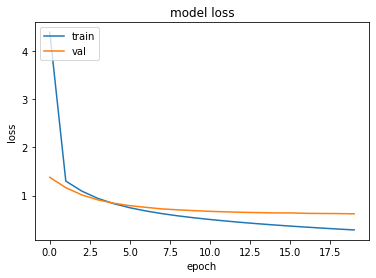

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

#### Searching hyperparameters
We will use keras tuner for searching hyperparameters. It have few different tuners which use different searching algorithms. We will use `BayesianOptimization` that is based on Bayesian search algorithm which is much better than simple grid search or random search.

In `build_model` function we specify structure of model and space of parameters to search. It's important to set `padding=same` parameter in `Conv1D` and `MaxPooling1D` layers, beacause for some combinations and kernels or pooling sizes there would be dimensions error (*e.g. big pool_size in previous layer reduced length of vector to 8 and next Conv1D layer have kernel with size of 9*).

I decided not to use `GlobalPooling`, because i wanted preserve some level of location information on account of fact that many negative reviews begins with very few compliments.

In [18]:
# crating explicit train and validation set
x_train_smaller, x_val, y_train_smaller, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=42)

In [67]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(MAX_NUM_WORDS, 300, weights=[embedding_matrix],
                          input_length=MAX_VECTOR_LEN, trainable=False))
    for i in range(hp.Int('n_layers', 1,5)):
        filters = hp.Int('filters_'+str(i), min_value=32,max_value=784,step=16)
        kernel_size = hp.Int('filter_size_'+str(i),min_value=3,max_value=9,step=2)
        pooling_size = hp.Int('pool_size_'+str(i),2,12, step=1)
        
        model.add(keras.layers.Conv1D(filters, kernel_size, activation='relu', padding='same'))
        model.add(keras.layers.MaxPooling1D(pooling_size, padding='same'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(hp.Float('dropout_rate', min_value=0.1,
                                           max_value=0.9, step=0.1)))
    model.add(keras.layers.Dense(hp.Int('dense_units', 16, 128, step=8)))
    model.add(keras.layers.Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate = hp.Choice('lr',[0.005,0.001, 0.0001, 0.00001, 0.000001])),
                  loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

In [71]:
import kerastuner as kt

tuner = kt.BayesianOptimization(build_model, objective='val_mean_squared_error',
                               max_trials=40)
tuner.search(x_train_smaller, y_train_smaller, epochs=10, validation_data=(x_val, y_val),
            verbose=2)

Trial 40 Complete [00h 00m 40s]
val_mean_squared_error: 0.7403683662414551

Best val_mean_squared_error So Far: 0.49662357568740845
Total elapsed time: 00h 43m 30s


In [72]:
tuner.get_best_hyperparameters(1)[0].values

{'n_layers': 5,
 'filters_0': 400,
 'filter_size_0': 3,
 'pool_size_0': 8,
 'dropout_rate': 0.4,
 'dense_units': 80,
 'lr': 0.001,
 'filters_1': 784,
 'filter_size_1': 3,
 'pool_size_1': 6,
 'filters_2': 400,
 'filter_size_2': 7,
 'pool_size_2': 10,
 'filters_3': 384,
 'filter_size_3': 7,
 'pool_size_3': 12,
 'filters_4': 448,
 'filter_size_4': 3,
 'pool_size_4': 2}

Structure of model with best found hyperparametes.

In [73]:
cnn_model = tuner.get_best_models(1)[0]
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          1500000   
_________________________________________________________________
conv1d (Conv1D)              (None, 300, 400)          360400    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 38, 400)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 38, 784)           941584    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 784)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 7, 400)            2195600   
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 400)            0

Model on test set has pretty good score.

In [74]:
y_pred = cnn_model.predict(x_test)
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

0.4726994458861257

In [75]:
# saving model for use in REST API
tf.keras.models.save_model(cnn_model, './cnn_model2')

In [76]:
import shutil
shutil.make_archive('cnn_model.zip', 'zip', './cnn_model2')

'/kaggle/working/cnn_model.zip.zip'